<a href="https://colab.research.google.com/github/filmerxyz/JSTP-22_SkinDiseaseClassificationUsingMachineLearning/blob/master/Grad_CAM_Ex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
import json
import cv2
import glob
import shutil

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.python.framework import ops
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.nasnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.resnet50 import decode_predictions

IMG_WIDTH = 224
IMG_HEIGHT = 224

In [0]:
tf.compat.v1.disable_eager_execution()

In [3]:
model = tf.keras.applications.ResNet50(weights='imagenet')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [4]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

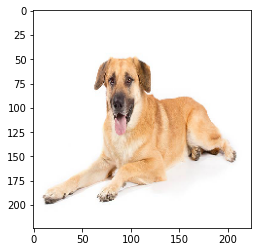

In [5]:
img_path = '/content/Chinook-On-White-03.jpg'
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)

In [0]:
def load_image(path, preprocess=True):
    """Load and preprocess image."""
    x = image.load_img(path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    if preprocess:
        x = image.img_to_array(x)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
    return x

In [0]:
def normalize(x):
    """Utility function to normalize a tensor by its L2 norm"""
    return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)

In [0]:
def deprocess_image(x):
    """Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    """
    x = x.copy()
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)
    # convert to RGB array
    x *= 255
    if tf.keras.backend.image_data_format() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [0]:
def guided_backprop(input_model, images, layer_name):
    """Guided Backpropagation method for visualizing input saliency."""
    input_imgs = input_model.input
    layer_output = input_model.get_layer(layer_name).output
    grads = tf.gradients(layer_output, input_imgs)[0]
    backprop_fn = K.function([input_imgs, K.learning_phase()], [grads])
    grads_val = backprop_fn([images, 0])[0]
    return grads_val

In [0]:
def grad_cam(input_model, image, cls, layer_name):
    """GradCAM method for visualizing input saliency."""
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    
    grads = K.gradients(y_c, conv_output)[0]
    # Normalize if necessary
    # grads = normalize(grads)
    gradient_function = K.function([input_model.input], [conv_output, grads])
    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)
    # Process CAM
    cam = cv2.resize(cam, (IMG_WIDTH, IMG_HEIGHT), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam

In [0]:
def grad_cam_batch(input_model, images, classes, layer_name):
    """GradCAM method for visualizing input saliency.
    Same as grad_cam but processes multiple images in one run."""
    loss = tf.gather_nd(input_model.output, np.dstack([range(images.shape[0]), classes])[0])
    layer_output = input_model.get_layer(layer_name).output
    grads = K.gradients(loss, layer_output)[0]
    gradient_fn = K.function([input_model.input, K.learning_phase()], [layer_output, grads])
    conv_output, grads_val = gradient_fn([images, 0])    
    weights = np.mean(grads_val, axis=(1, 2))
    cams = np.einsum('ijkl,il->ijk', conv_output, weights)
    # Process CAMs
    new_cams = np.empty((images.shape[0], IMG_HEIGHT, IMG_WIDTH))
    for i in range(new_cams.shape[0]):
        cam_i = cams[i] - cams[i].mean()
        cam_i = (cam_i + 1e-10) / (np.linalg.norm(cam_i, 2) + 1e-10)
        new_cams[i] = cv2.resize(cam_i, (IMG_WIDTH, IMG_HEIGHT), cv2.INTER_LINEAR)
        new_cams[i] = np.maximum(new_cams[i], 0)
        new_cams[i] = new_cams[i] / new_cams[i].max()
    return new_cams

In [0]:
def compute_saliency(model, guided_model, img_path, layer_name='block5_conv3', cls=-1, visualize=True, save=True):
    """Compute saliency using all three approaches.
        -layer_name: layer to compute gradients;
        -cls: class number to localize (-1 for most probable class).
    """
    preprocessed_input = load_image(img_path)
    predictions = model.predict(preprocessed_input)
    top_n = 5
    top = decode_predictions(predictions, top=top_n)[0]
    classes = np.argsort(predictions[0])[-top_n:][::-1]
    print('Model prediction:')
    for c, p in zip(classes, top):
        print('\t{:15s}\t({})\twith probability {:.3f}'.format(p[1], c, p[2]))
    if cls == -1:
        cls = np.argmax(predictions)
    class_name = decode_predictions(np.eye(1, 1000, cls))[0][0][1]
    print("Explanation for '{}'".format(class_name))  
    gradcam = grad_cam(model, preprocessed_input, cls, layer_name)
    gb = guided_backprop(guided_model, preprocessed_input, layer_name)
    guided_gradcam = gb * gradcam[..., np.newaxis]
    if save:
        jetcam = cv2.applyColorMap(np.uint8(255 * gradcam), cv2.COLORMAP_JET)
        jetcam = (np.float32(jetcam) + load_image(img_path, preprocess=False)) / 2
        cv2.imwrite('gradcam.jpg', np.uint8(jetcam))
        cv2.imwrite('guided_backprop.jpg', deprocess_image(gb[0]))
        cv2.imwrite('guided_gradcam.jpg', deprocess_image(guided_gradcam[0]))
    if visualize:
        plt.figure(figsize=(15, 10))
        plt.subplot(131)
        plt.title('GradCAM')
        plt.axis('off')
        plt.imshow(load_image(img_path, preprocess=False))
        plt.imshow(gradcam, cmap='jet', alpha=0.5)
        plt.subplot(132)
        plt.title('Guided Backprop')
        plt.axis('off')
        plt.imshow(np.flip(deprocess_image(gb[0]), -1))
        plt.subplot(133)
        plt.title('Guided GradCAM')
        plt.axis('off')
        plt.imshow(np.flip(deprocess_image(guided_gradcam[0]), -1))
        plt.show()      
    return gradcam, gb, guided_gradcam

Model prediction:
	nematode       	(111)	with probability 0.123
	matchstick     	(644)	with probability 0.033
	nail           	(677)	with probability 0.027
	cleaver        	(499)	with probability 0.024
	ballpoint      	(418)	with probability 0.020
Explanation for 'nematode'


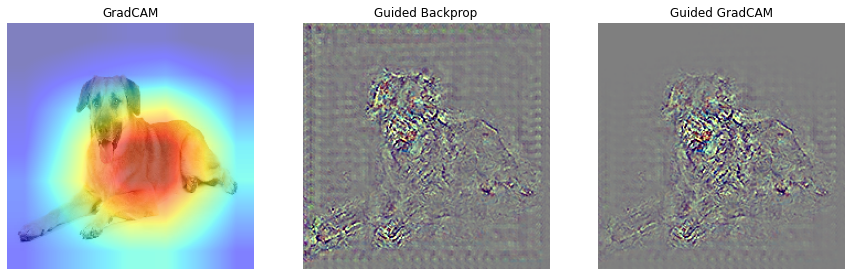

In [13]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, img_path, layer_name='conv5_block3_3_conv')